In [3]:
%matplotlib inline

import sys

import numpy as np

import py_src.agent_based as ab

import scipy.optimize

import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as aa

import ipywidgets as wi

from mpl_toolkits.mplot3d import Axes3D

from itertools import chain

import os.path

# 1. Simulación basada en agentes

In [4]:
params = {
    # Hops:
    "hops_lynx": 2,
    "hops_lynx_eat": 2,
    "hops_hare": 1,
    # Probs:
    "prob_hare_hop": 1.0,
    "prob_hare_repr": 0.045,
    "prob_lynx_hop": 1.0,
    "prob_lynx_eat": 0.10,
    "prob_lynx_dead": 0.05,
    "prob_lynx_repr": 0.8,
}
size = 50

In [5]:
model = ab.AgentModel(size=size,n_hares=100,n_lynxs=100,prs=params)
hares = []
lynxs = []
inters = []
for t in range(1000):
    hares.append(model.hares.copy())
    lynxs.append(model.lynxs.copy())
    sys.stdout.write("\r%5d %5d %5d"%(t,np.sum(hares[-1]),np.sum(lynxs[-1])))
    sys.stdout.flush()
    res = model.step()
    inters.append(model.n_interactions)
    if not res: break

   99    66     0

In [7]:
nhs = [np.sum(x) for x in hares]
nls = [np.sum(x) for x in lynxs]
inters = np.array(inters)

def plot_time(t):
    img = np.ones((model.size,model.size,3))
    img[hares[t]>=1,:] = [0,0,1]
    img[lynxs[t]>=1,:] = [1,0,0]
    #
    f, axarr = plt.subplots(1,2,figsize=(12,6))
    axarr[0].set_title('Ubicación monines')
    axarr[0].imshow(img)
    axarr[1].set_title('Cantidad monines')
    axarr[1].plot(inters,color=(0.4,0.4,0))
    axarr[1].plot(nhs,color=(0,0,0.4))
    axarr[1].plot(nls,color=(0.4,0,0))
    axarr[1].plot(inters[:t+1],color="yellow")
    axarr[1].plot(nhs[:t+1],color="blue")
    axarr[1].plot(nls[:t+1],color="red")
    

interactive_plot = wi.interact(plot_time,t=wi.Play(min=0,max=len(hares)-1))
interactive_plot;

interactive(children=(Play(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',))

# 2. Modelo macro

Se busca obtener funciones para la evolución del sistema de la forma:
$$
\frac{dH}{dt} = f(H,L,I)
\\ \frac{dL}{dt} = g(H,L,I)
\\ \frac{dI}{dt} = h(H,L,I)
$$

Donde $I$ es la cantidad de interacciones entre lobos y conejos:
$$
I = \sum_{l \in \text{lynxs}}{\text{conejos al alcance de $l$}} = 
\sum_{h \in \text{hares}}{\text{lobos que alcanzan a $h$}}
$$
esperando que sea capaz de describir el estado del sistema.

La cantidad inicial de interacciones $I_0$ se estima como:
$$
I_0 = \frac{(2\cdot 2+1)^2}{S^2} H L = \frac{25}{S^2} H L
$$

Se busca descubrir estas funciones, para lo cual se obtienen varias muestras a partir de varias simulaciones.

In [8]:
if not os.path.isfile("data/pts_dil_a.npy"):
    n_repeats = 2
    n_iters = 2000
    start_hares = range(40,101,20)
    start_lynxs = range(40,101,20)
    size = 50

    pts_ha = []
    pts_ly = []
    pts_il = []
    pts_dha = []
    pts_dly = []
    pts_dil = []

    for sha in start_hares:
        for sly in start_lynxs:
            for re in range(n_repeats):
                ha = []
                ly = []
                il = []
                model = ab.AgentModel(size=size,n_hares=sha,n_lynxs=sly,prs=params)
                for t in range(n_iters):
                    ha.append(model.n_hares)
                    ly.append(model.n_lynxs)
                    res = model.step()
                    il.append(model.n_interactions)
                    if not res: break
                    #
                    sys.stdout.write("\r%5d %5d %5d/%d %5d/%d"%(sha,sly,re,n_repeats,t,n_iters))
                    sys.stdout.flush()
                ha = np.array(ha)
                ly = np.array(ly)
                il = np.array(il)
                """
                if len(ha)<3: continue
                # Calculate differences
                dha = (ha[2:]-ha[:-2])/2.0
                dly = (ly[2:]-ly[:-2])/2.0
                dil = (il[2:]-il[:-2])/2.0
                # Discard the first and last point.
                ha = ha[1:-1]
                ly = ly[1:-1]
                il = il[1:-1]
                #
                """
                if len(ha)<2: continue
                dha = ha[1:]-ha[:-1]
                dly = ly[1:]-ly[:-1]
                dil = il[1:]-il[:-1]
                ha = ha[:-1]
                ly = ly[:-1]
                il = il[:-1]
                pts_ha.append(ha)
                pts_ly.append(ly)
                pts_il.append(il)
                pts_dha.append(dha)
                pts_dly.append(dly)
                pts_dil.append(dil)
                
    print("\npacking.")
    pts_ha_a = np.array(list(chain(*pts_ha)))
    pts_ly_a = np.array(list(chain(*pts_ly)))
    pts_il_a = np.array(list(chain(*pts_il)))
    pts_dha_a = np.array(list(chain(*pts_dha)))
    pts_dly_a = np.array(list(chain(*pts_dly)))
    pts_dil_a = np.array(list(chain(*pts_dil)))
    np.save("data/pts_ha_a.npy",pts_ha_a)
    np.save("data/pts_ly_a.npy",pts_ly_a)
    np.save("data/pts_il_a.npy",pts_il_a)
    np.save("data/pts_dha_a.npy",pts_dha_a)
    np.save("data/pts_dly_a.npy",pts_dly_a)
    np.save("data/pts_dil_a.npy",pts_dil_a)


  100   100     1/2   491/2000
packing.


In [9]:
pts_ha_a = np.load("data/pts_ha_a.npy")
pts_ly_a = np.load("data/pts_ly_a.npy")
pts_il_a = np.load("data/pts_il_a.npy")
pts_dha_a = np.load("data/pts_dha_a.npy")
pts_dly_a = np.load("data/pts_dly_a.npy")
pts_dil_a = np.load("data/pts_dil_a.npy")

# Uncoment to only work with ha and ly
#pts_il_a = np.zeros(pts_ha_a.shape)
#pts_dil_a = np.zeros(pts_ha_a.shape)

/home/fcasas/Documents/envs/cc4/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


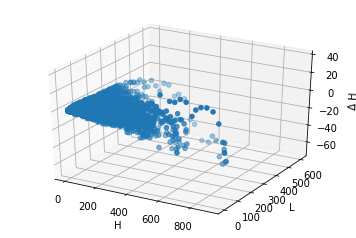

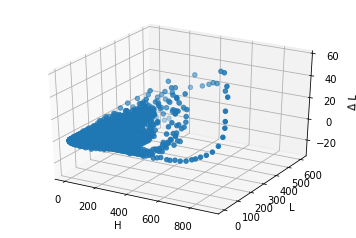

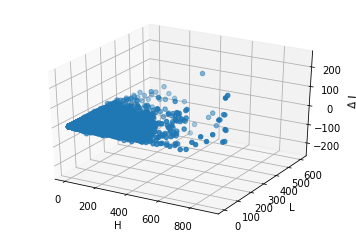

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts_ha_a,pts_ly_a,pts_dha_a)
ax.set_xlabel('H')
ax.set_ylabel('L')
ax.set_zlabel('$\Delta$ H')
fig.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts_ha_a,pts_ly_a,pts_dly_a)
ax.set_xlabel('H')
ax.set_ylabel('L')
ax.set_zlabel('$\Delta$ L')
fig.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts_ha_a,pts_ly_a,pts_dil_a)
ax.set_xlabel('H')
ax.set_ylabel('L')
ax.set_zlabel('$\Delta$ I')
fig.show();

In [11]:
def polyeval(ha,ly,il,coefs):
    return (coefs[0]+coefs[1]*ha+coefs[2]*ly+coefs[3]*il+
        coefs[4]*ha**2+coefs[5]*ly**2+coefs[6]*il**2+
        coefs[7]*ha*ly+coefs[8]*ly*il+coefs[9]*il*ha)

def poly2d(coefs,target):
    return polyeval(pts_ha_a,pts_ly_a,pts_il_a,coefs)-target

def str_poly2d(coefs):
    return "%+f%+fH%+fL%+fI\n\t%+fH^2%+fL^2%+fI^2\n\t%+fHL%+fLI%+fHI"%tuple(coefs)

print("hares")
res = scipy.optimize.leastsq(lambda x: poly2d(x,pts_dha_a),np.zeros(10))
dha_coefs = res[0]
print("dH/dt = %s"%str_poly2d(dha_coefs))
print("lynxs")
res = scipy.optimize.leastsq(lambda x: poly2d(x,pts_dly_a),np.zeros(10))
dly_coefs = res[0]
print("dL/dt = %s"%str_poly2d(dly_coefs))
print("interactions")
res = scipy.optimize.leastsq(lambda x: poly2d(x,pts_dil_a),np.zeros(10))
dil_coefs = res[0]
print("dI/dt = %s"%str_poly2d(dil_coefs))

hares
dH/dt = +0.018494+0.045311H-0.001032L-0.083307I
	-0.000000H^2+0.000005L^2+0.000020I^2
	-0.000180HL+0.000036LI+0.000004HI
lynxs
dL/dt = -0.054556+0.000296H-0.048038L+0.061809I
	+0.000001H^2-0.000006L^2-0.000004I^2
	+0.000121HL-0.000038LI-0.000015HI
interactions
dI/dt = -0.099618+0.011158H-0.012076L-0.188875I
	+0.000010H^2+0.000002L^2-0.000107I^2
	+0.001724HL-0.000569LI+0.000273HI


Computed I_0:  94.1
Estimated I_0:  100.0


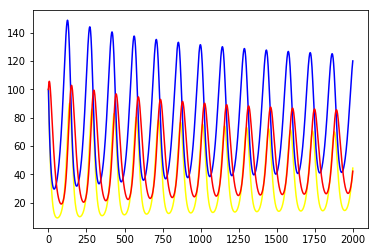

In [17]:
ha = [100]
ly = [100]

# Compute initial il:
init_ils = []
for k in range(30):
    model = ab.AgentModel(size=size,n_hares=ha[-1],n_lynxs=ly[-1],prs=params)
    model.step()
    init_ils.append(model.n_interactions)
computed_il = np.mean(init_ils)
estimated_il = 25*ha[-1]*ly[-1]/size**2
print("Computed I_0: ",computed_il)
print("Estimated I_0: ",estimated_il)
il = [estimated_il]
# Euler's method:
for i in range(2000):
    dha = polyeval(ha[-1],ly[-1],il[-1],dha_coefs)
    dly = polyeval(ha[-1],ly[-1],il[-1],dly_coefs)
    dil = polyeval(ha[-1],ly[-1],il[-1],dil_coefs)
    ha.append(ha[-1]+dha)
    ly.append(ly[-1]+dly)
    il.append(il[-1]+dil)
# Graph:
plt.plot(il,color="yellow")
plt.plot(ha,color="blue")
plt.plot(ly,color="red");

Ignorando lo que sucede en las esquinas, un conejo que salta 1 tiene una probabilidad de:
$$
\frac{3}{9} \frac{S}{S^2} = \frac{1}{3S}
$$
de saltar fuera de su espacio (por un lado particular, e.g. norte) correspondiente.

De la misma manera, un lobo tiene una probabilidad de:
$$
\frac{10}{25} \frac{S}{S^2} + \frac{5}{25} \frac{S}{S^2} = \frac{3}{5S}
$$

Entonces las fórmulas de actualización de las variables del modelo para un bloque $i,j$ son:
\begin{align*}
\Delta H_{i\ j} &= f(H_{i\ j},L_{i\ j},I_{i\ j}) - \frac{4 H_{i\ j}}{3S}
+ \frac{H_{i+1\ j}}{3S}
+ \frac{H_{i\ j+1}}{3S}
+ \frac{H_{i-1\ j}}{3S}
+ \frac{H_{i\ j-1}}{3S}
\\ \Delta L_{i\ j} &= g(H_{i\ j},L_{i\ j},I_{i\ j}) - \frac{12 L_{i\ j}}{5S}
+ \frac{3L_{i+1\ j}}{5S}
+ \frac{3L_{i\ j+1}}{5S}
+ \frac{3L_{i-1\ j}}{5S}
+ \frac{3L_{i\ j-1}}{5S}
\\ \Delta I_{i\ j} &= h(H_{i\ j},L_{i\ j},I_{i\ j}) + \underbrace{\frac{25}{S^2}(\Delta H_{i\ j}) L_{i\ j}
+ \frac{25}{S^2}(\Delta L_{i\ j}) H_{i\ j} + \frac{25}{S^2}(\Delta H_{i\ j})(\Delta L_{i\ j}) }_{\text{Estimación de nuevas interacciones}}
\end{align*}

Se comienza con una cantidad aleatoria de monines en cada celda.

In [21]:
metasize = 20

def warp_matrix(mat):
    wmat = np.zeros((mat.shape[0]+2,mat.shape[1]+2))
    wmat[1:-1,1:-1] = mat
    wmat[0,1:-1] = mat[-1,:]
    wmat[1:-1,0] = mat[:,-1]
    wmat[-1,1:-1] = mat[0,:]
    wmat[1:-1,-1] = mat[:,0]
    return wmat

m_ha = [np.random.random((metasize,metasize))*100]
m_ly = [np.random.random((metasize,metasize))*100]
m_il = [(m_ha[-1]*m_ly[-1]*25.0+size*size/2.0)/size**2]

for i in range(1000):
    warp_m_ha = warp_matrix(m_ha[-1])
    warp_m_ly = warp_matrix(m_ly[-1])
    #
    m_dha = (polyeval(m_ha[-1],m_ly[-1],m_il[-1],dha_coefs)
        -4.0*m_ha[-1]/(3.0*size)
        +warp_m_ha[:-2,1:-1]/(3.0*size)
        +warp_m_ha[1:-1,:-2]/(3.0*size)
        +warp_m_ha[2:,1:-1]/(3.0*size)
        +warp_m_ha[1:-1,2:]/(3.0*size))
    m_dly = (polyeval(m_ha[-1],m_ly[-1],m_il[-1],dly_coefs)
        -12*warp_m_ly[1:-1,1:-1]/(5.0*size)
        +3*warp_m_ly[:-2,1:-1]/(5.0*size)
        +3*warp_m_ly[1:-1,:-2]/(5.0*size)
        +3*warp_m_ly[2:,1:-1]/(5.0*size)
        +3*warp_m_ly[1:-1,2:]/(5.0*size))
    m_dil = (polyeval(m_ha[-1],m_ly[-1],m_il[-1],dil_coefs)
        +25.0/(size*size)*m_ha[-1]*m_dly
        +25.0/(size*size)*m_ly[-1]*m_dha
        +25.0/(size*size)*m_dha*m_dly)
    #
    m_ha.append(m_ha[-1]+m_dha)
    m_ly.append(m_ly[-1]+m_dly)
    m_il.append(m_il[-1]+m_dil)

In [36]:
ha_sum = [np.sum(x) for x in m_ha]
ly_sum = [np.sum(x) for x in m_ly]
il_sum = [np.sum(x) for x in m_il]

def plot_time_adj(t):
    #
    img = np.zeros((m_ha[0].shape[0],m_ha[0].shape[1],3))
    img[:,:,2] = m_ha[t]/100.0
    img[:,:,0] = m_ly[t]/100.0
    f, axarr = plt.subplots(1,2,figsize=(12,6))
    axarr[0].set_title('Ubicación monines simulaciones adyacentes')
    axarr[0].imshow(img)
    axarr[1].set_title('Cantidad monines total')
    axarr[1].plot(il_sum,color=(0.4,0.4,0))
    axarr[1].plot(ha_sum,color=(0,0,0.4))
    axarr[1].plot(ly_sum,color=(0.4,0,0))
    axarr[1].plot(il_sum[:t+1],color="yellow")
    axarr[1].plot(ha_sum[:t+1],color="blue")
    axarr[1].plot(ly_sum[:t+1],color="red")

interactive_plot = wi.interact(plot_time_adj,t=wi.Play(min=0,max=len(m_ha)-1))
interactive_plot.widget.layout.height = '500px'
interactive_plot;

interactive(children=(Play(value=0, description='t', max=1000), Output()), _dom_classes=('widget-interact',))